<a href="https://colab.research.google.com/github/Salanakya/Flight-Cancellations/blob/main/flight_cancellations_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyzing the predictability of flight cancellations for Clients' flight booking app.
Based on 2015 data
https://www.kaggle.com/datasets/usdot/flight-delays

YEAR, MONTH, DAY, DAY_OF_WEEK: dates of the flight 
AIRLINE: An identification number assigned by US DOT to identify a unique airline 
ORIGIN_AIRPORT and DESTINATION_AIRPORT: code attributed by IATA to identify the airports 
SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : scheduled times of take-off and landing 
DEPARTURE_TIME and ARRIVAL_TIME: real times at which take-off and landing took place 
DEPARTURE_DELAY and ARRIVAL_DELAY: difference (in minutes) between planned and real times 
DISTANCE: distance (in miles) 








##Kaggle - dataset import

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d usdot/flight-delays

In [ ]:
!unzip flight-delays.zip

##Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score, roc_auc_score

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB


from sklearn.preprocessing import OneHotEncoder

##Data exploration and preprocessing

In [4]:
airlines = pd.read_csv('airlines.csv')
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [5]:
flights = pd.read_csv('flights.csv')
flights

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,...,753.0,-26.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,...,430.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,...,432.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,...,330.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

Dataset description: 



*   YEAR, MONTH, DAY, DAY_OF_WEEK: dates of the flight


*   AIRLINE: An identification number assigned by US DOT to identify a unique airline 

*   ORIGIN_AIRPORT and DESTINATION_AIRPORT: code attributed by IATA to identify the airports 

*   SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : scheduled times of take-off and landing 
*   DEPARTURE_TIME and ARRIVAL_TIME: real times at which take-off and landing took place 


*   DEPARTURE_DELAY and ARRIVAL_DELAY: difference (in minutes) between planned and real times  


*   DISTANCE: distance (in miles) 


In [ ]:
#columns that are more than 25% empty; among those only CANCELLATION_REASON is relevant
flights.isna().mean() >0.25

YEAR                   False
MONTH                  False
DAY                    False
DAY_OF_WEEK            False
AIRLINE                False
FLIGHT_NUMBER          False
TAIL_NUMBER            False
ORIGIN_AIRPORT         False
DESTINATION_AIRPORT    False
SCHEDULED_DEPARTURE    False
DEPARTURE_TIME         False
DEPARTURE_DELAY        False
TAXI_OUT               False
WHEELS_OFF             False
SCHEDULED_TIME         False
ELAPSED_TIME           False
AIR_TIME               False
DISTANCE               False
WHEELS_ON              False
TAXI_IN                False
SCHEDULED_ARRIVAL      False
ARRIVAL_TIME           False
ARRIVAL_DELAY          False
DIVERTED               False
CANCELLED              False
CANCELLATION_REASON     True
AIR_SYSTEM_DELAY        True
SECURITY_DELAY          True
AIRLINE_DELAY           True
LATE_AIRCRAFT_DELAY     True
WEATHER_DELAY           True
dtype: bool

Reading only relevant columns from the dataset.

In [6]:
flights = pd.read_csv('flights.csv', usecols = ['MONTH','DAY','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DISTANCE','SCHEDULED_ARRIVAL','CANCELLED', 'CANCELLATION_REASON'])
flights

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_ARRIVAL,CANCELLED,CANCELLATION_REASON
0,1,1,4,AS,ANC,SEA,1448,430,0,NaN
1,1,1,4,AA,LAX,PBI,2330,750,0,NaN
2,1,1,4,US,SFO,CLT,2296,806,0,NaN
3,1,1,4,AA,LAX,MIA,2342,805,0,NaN
4,1,1,4,AS,SEA,ANC,1448,320,0,NaN
...,...,...,...,...,...,...,...,...,...,...
5819074,12,31,4,B6,LAX,BOS,2611,819,0,NaN
5819075,12,31,4,B6,JFK,PSE,1617,446,0,NaN
5819076,12,31,4,B6,JFK,SJU,1598,440,0,NaN
5819077,12,31,4,B6,MCO,SJU,1189,340,0,NaN


In [5]:
flights['CANCELLED'].value_counts()

0    5729195
1      89884
Name: CANCELLED, dtype: int64

Cancelled flights are only 2% of all flights. While the number is miniscule, implementing cancel checks into the Clients app would be beneficial for user experience, if they lead to good predictability.

In [7]:
# joining airlines
flights = flights.merge(airlines, left_on='AIRLINE', right_on='IATA_CODE', how='inner')

In [8]:
# dropping old column and renaming new one
flights = flights.drop(['AIRLINE_x','IATA_CODE'], axis=1)
flights = flights.rename(columns={"AIRLINE_y":"AIRLINE"})

In [ ]:
flights

,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_ARRIVAL,CANCELLED,CANCELLATION_REASON,AIRLINE
0,1,1,4,ANC,SEA,1448,430,0,NaN,Alaska Airlines Inc.
1,1,1,4,SEA,ANC,1448,320,0,NaN,Alaska Airlines Inc.
2,1,1,4,ANC,SEA,1448,509,0,NaN,Alaska Airlines Inc.
3,1,1,4,ANC,PDX,1542,525,0,NaN,Alaska Airlines Inc.
4,1,1,4,FAI,SEA,1533,548,0,NaN,Alaska Airlines Inc.
...,...,...,...,...,...,...,...,...,...,...
5819074,12,31,4,LGA,DAL,1381,2200,0,NaN,Virgin America
5819075,12,31,4,BOS,SFO,2704,2250,0,NaN,Virgin America
5819076,12,31,4,SFO,LAS,414,2110,0,NaN,Virgin America
5819077,12,31,4,LAX,LAS,236,2055,0,NaN,Virgin America


##Visual Data Analysis

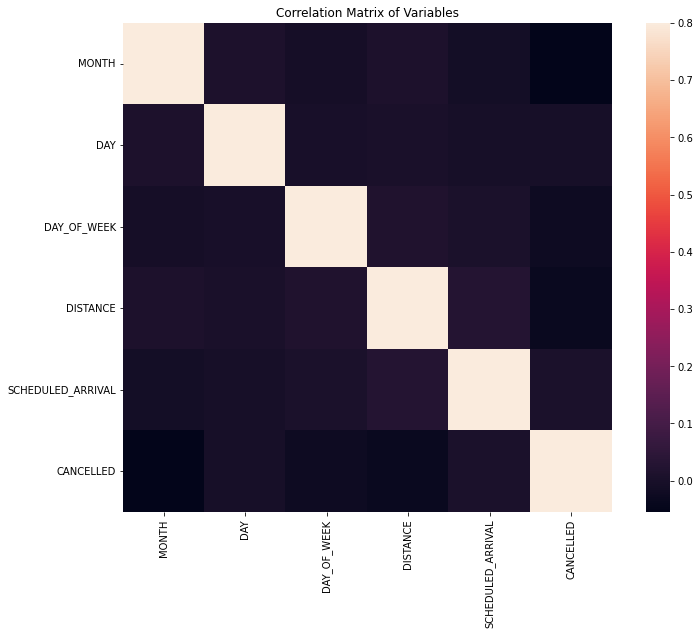

In [8]:
corrmat = flights.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.title("Correlation Matrix of Variables")
plt.show()

Correlation matrix shows  no correlations, which does not bode well for our project.

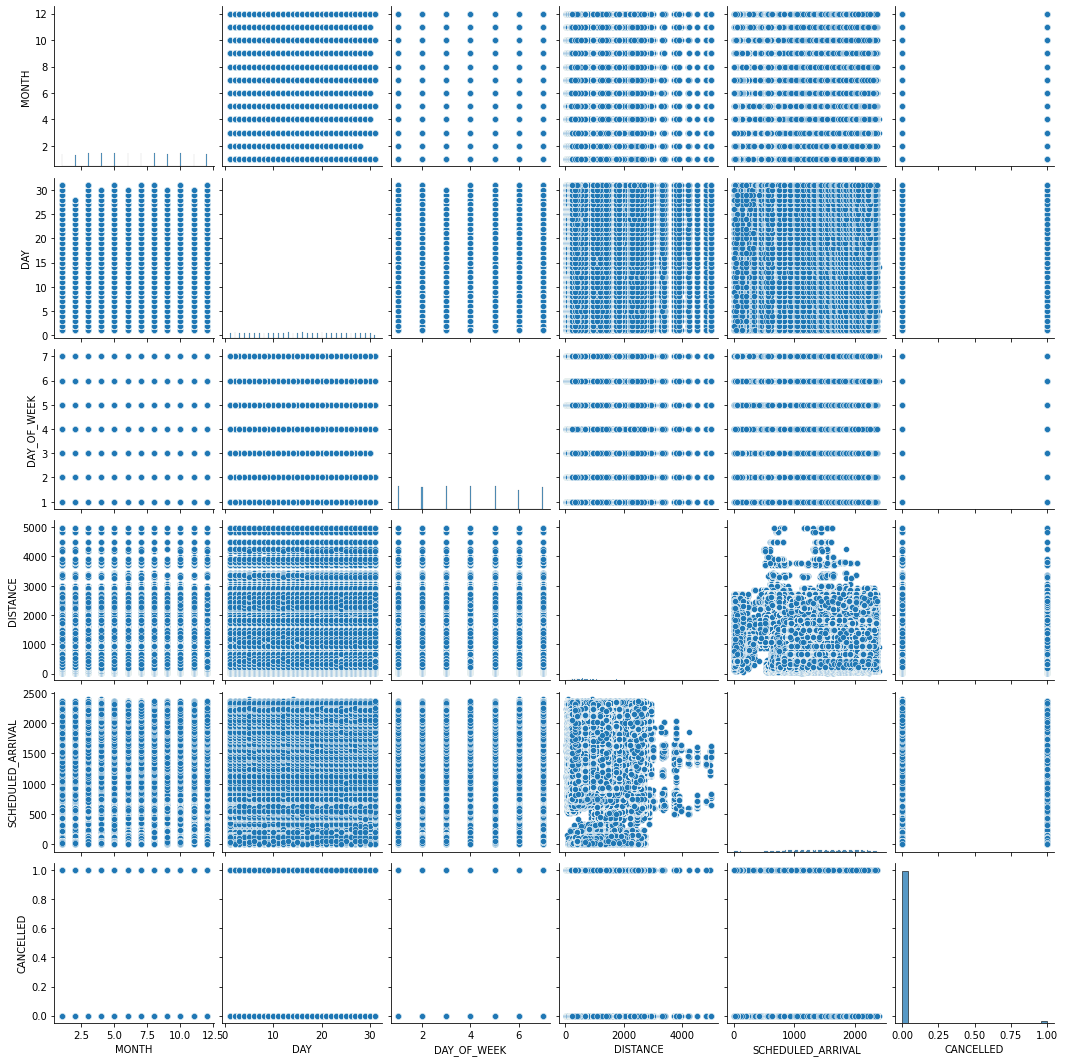

In [ ]:
sns.pairplot(flights)
plt.show()

The same can be said about pairplot. Cancellations do not result from metrics included in the dataset.

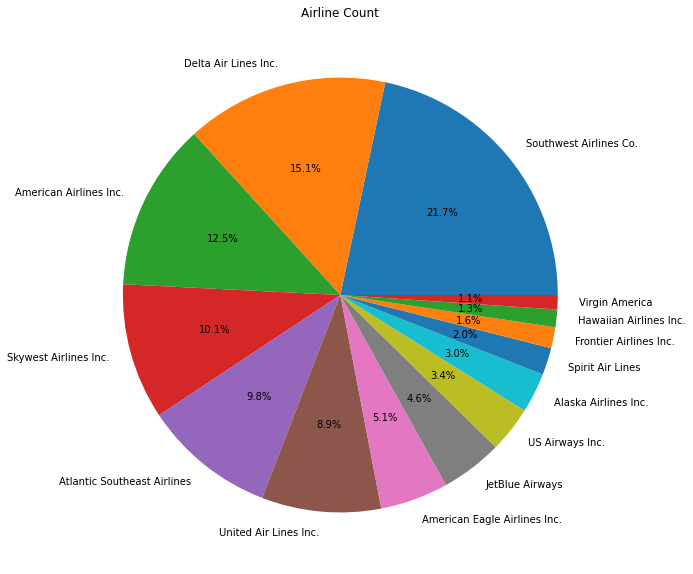

In [9]:
#total flights volume by airline

airlines_names = list(flights['AIRLINE'].value_counts().index)
plt.figure(figsize=(15,10))
plt.pie(flights['AIRLINE'].value_counts(), autopct = '%1.1f%%', labels = airlines_names)
plt.title("Airline Count")
plt.show()




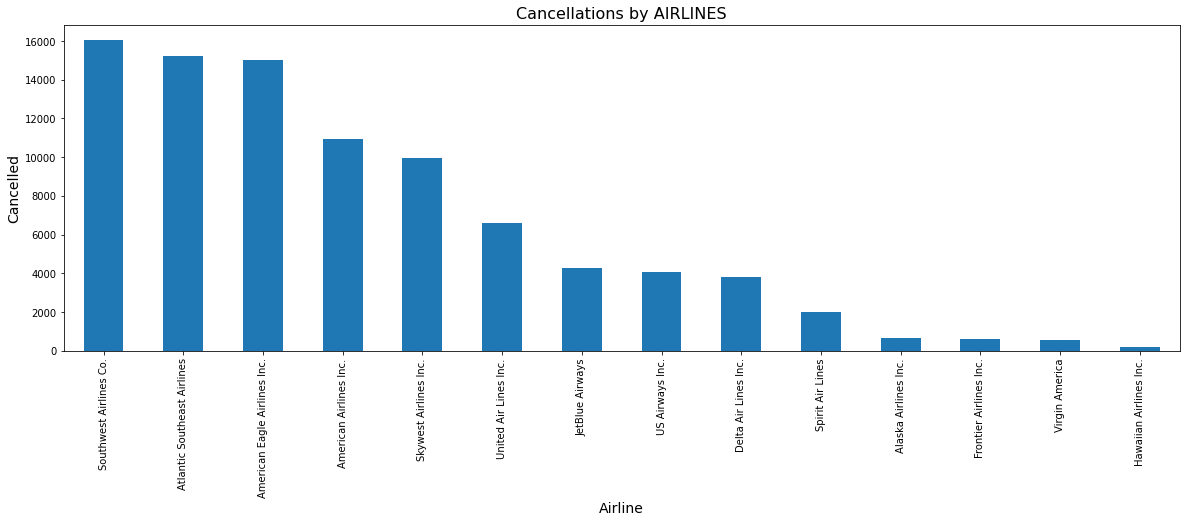

In [10]:
#Cancellations by airlines
plt.figure(figsize=(20, 6))
flights.groupby('AIRLINE').CANCELLED.sum().sort_values(ascending=False).plot.bar()
plt.title('Cancellations by AIRLINES', fontsize=16)
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Cancelled', fontsize=14)
plt.show()



Considering total flights by airline, it is no surprise that No #1 in amount of flights is also the No #1 in cancellations. However, the ratio does not continue. Atlantic Southeast Airlines is second in cancellations amount while contributing to only 10% of all airline traffic. Surprisingly, Delta Air Lines has a remarkably low amount of cancellations compared to their flights volume.

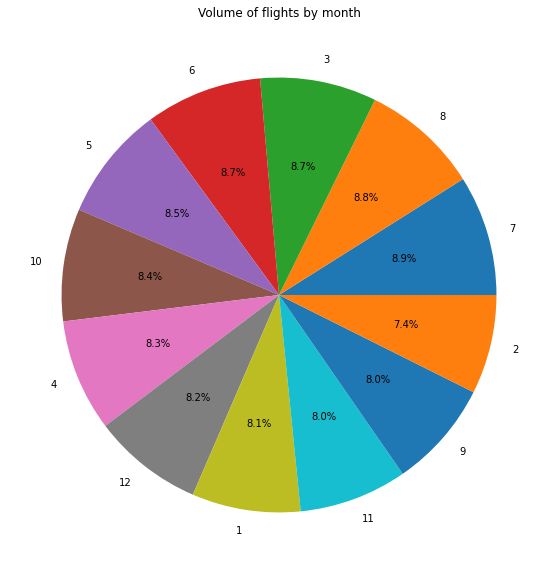

In [13]:
#total flights volume by month
months = list(flights['MONTH'].value_counts().index)
plt.figure(figsize=(15,10))
plt.pie(flights['MONTH'].value_counts(), autopct = '%1.1f%%', labels = months)
plt.title("Volume of flights by month")
plt.show()


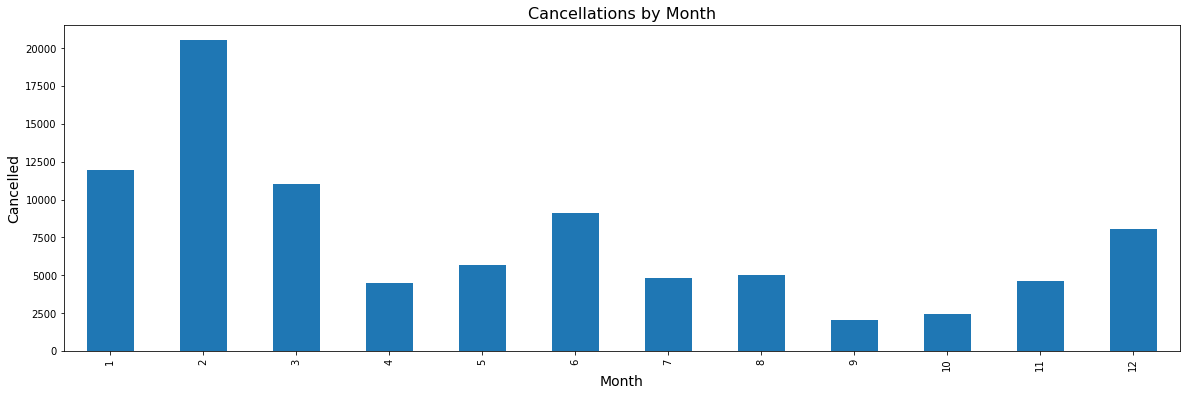

In [12]:
#Cancellations by month
plt.figure(figsize=(20, 6))
flights.groupby('MONTH').CANCELLED.sum().plot.bar()
plt.title('Cancellations by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Cancelled', fontsize=14)
plt.show()


Significant increase in cancellations in February while the total amount of flights is the years' lowest. According to historical data, at that time USA was experiencing a polar vortex which is a plausible cause for beforementioned trends in data.

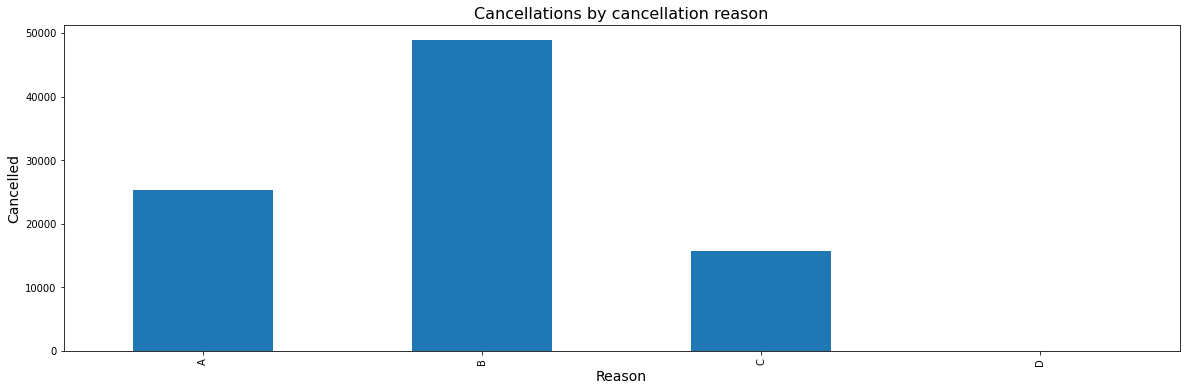

In [ ]:
#Cancellations by reason
plt.figure(figsize=(20, 6))
flights.groupby('CANCELLATION_REASON').CANCELLED.sum().plot.bar()
plt.title('Cancellations by cancellation reason', fontsize=16)
plt.xlabel('Reason', fontsize=14)
plt.ylabel('Cancelled', fontsize=14)
plt.show()


    A - Airline/Carrier
    B - Weather
    C - National Air System
    D - Security

Most cancellations were due to weather, which is somewhat predictable. Carrier and NAS reasons are impossible to predict, and Security reasons can be omitted.

In conclusion, the data is too scarce to create any correlations or predictions - just 2% of a dataset is not enough to form any remarks. Predicting the weather seems to have the biggest impact on flight cancellations, however that cannot be done with given dataset about flights.

##Prediction models

###OneHotEncoding

In [14]:
#picking only December data to preserve RAM resources

flights_December = flights[flights['MONTH'] >= 12]
flights_December = flights

In [15]:
dummy_airline = pd.get_dummies(flights_December.AIRLINE)
dummy_airline

,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5819075,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5819076,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5819077,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [16]:
flights_December = pd.merge(
    left=flights_December,
    right=dummy_airline,
    left_index=True,
    right_index=True,
)

In [17]:
flights_December

,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_ARRIVAL,CANCELLED,CANCELLATION_REASON,AIRLINE,...,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
0,1,1,4,ANC,SEA,1448,430,0,NaN,Alaska Airlines Inc.,...,0,0,0,0,0,0,0,0,0,0
1,1,1,4,SEA,ANC,1448,320,0,NaN,Alaska Airlines Inc.,...,0,0,0,0,0,0,0,0,0,0
2,1,1,4,ANC,SEA,1448,509,0,NaN,Alaska Airlines Inc.,...,0,0,0,0,0,0,0,0,0,0
3,1,1,4,ANC,PDX,1542,525,0,NaN,Alaska Airlines Inc.,...,0,0,0,0,0,0,0,0,0,0
4,1,1,4,FAI,SEA,1533,548,0,NaN,Alaska Airlines Inc.,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,12,31,4,LGA,DAL,1381,2200,0,NaN,Virgin America,...,0,0,0,0,0,0,0,0,0,1
5819075,12,31,4,BOS,SFO,2704,2250,0,NaN,Virgin America,...,0,0,0,0,0,0,0,0,0,1
5819076,12,31,4,SFO,LAS,414,2110,0,NaN,Virgin America,...,0,0,0,0,0,0,0,0,0,1
5819077,12,31,4,LAX,LAS,236,2055,0,NaN,Virgin America,...,0,0,0,0,0,0,0,0,0,1


In [18]:
#dropping unnecessary columns
flights_December = flights_December.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE', 'SCHEDULED_ARRIVAL', 'CANCELLATION_REASON', 'AIRLINE'], axis=1)

In [19]:
flights_December['CANCELLED'].value_counts()

0    5729195
1      89884
Name: CANCELLED, dtype: int64

###Test and Train split

In [20]:
dfCancelled = flights_December.copy()
X, y = dfCancelled.drop(['CANCELLED'], axis=1), dfCancelled['CANCELLED']
dfCancelled

,MONTH,DAY,DAY_OF_WEEK,CANCELLED,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
0,1,1,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,12,31,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5819075,12,31,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5819076,12,31,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5819077,12,31,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=13)

In [22]:
kfold = StratifiedKFold(n_splits=15)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train, X_test)

StandardScaler()

In [24]:
y_train.value_counts()

0    4010382
1      62973
Name: CANCELLED, dtype: int64

In [25]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4073355, 17) (4073355,)
Test set: (1745724, 17) (1745724,)


###Logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression

reg = 0.01

LogReg_model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)
print (LogReg_model)

LogisticRegression(C=100.0, solver='liblinear')


In [27]:
LogReg_predictions = LogReg_model.predict(X_test)
print('Predicted labels: ', LogReg_predictions[:5], LogReg_predictions[-5:])
print('Actual labels:    ' , y_test[:5].values, y_test[-5:].values)

Predicted labels:  [0 0 0 0 0] [0 0 0 0 0]
Actual labels:     [0 0 0 0 0] [0 0 0 0 0]


In [28]:
#model evaluation
print(classification_report(y_test, LogReg_predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1718813
           1       0.00      0.00      0.00     26911

    accuracy                           0.98   1745724
   macro avg       0.49      0.50      0.50   1745724
weighted avg       0.97      0.98      0.98   1745724



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


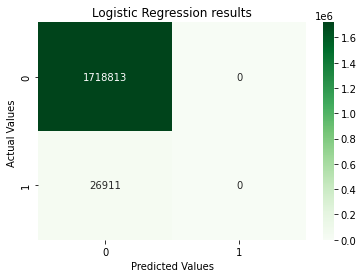

In [29]:
#confusion matrix
cm = confusion_matrix(y_test, LogReg_predictions)

ax = sns.heatmap(cm, annot=True, cmap='Greens', fmt='.0f')

ax.set_title('Logistic Regression results')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

While the first model correctly predicted most of the non-cancelled flights, lack of predictions for truly negatives raises a question whether the model works.

###Naive Bayes

In [40]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
prediction_gnb = gnb.predict(X_test)

In [41]:
print('Bayes')
print(classification_report(y_test, prediction_gnb))

Bayes
              precision    recall  f1-score   support

           0       0.99      0.84      0.91   1718813
           1       0.03      0.36      0.06     26911

    accuracy                           0.84   1745724
   macro avg       0.51      0.60      0.49   1745724
weighted avg       0.97      0.84      0.90   1745724



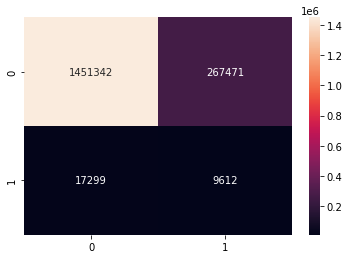

In [42]:
cm_test = confusion_matrix(y_test, prediction_gnb)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

Logistic regression has better scores, however given that no predicions were made for negatives, it is better to use the Bayes model.

##Saving model joblib

In [ ]:
import joblib
import pickle

Cancel_model=prediction_gnb
# save the model to disk
filename = 'Cancel_model.sav'
pickle.dump(Cancel_model, open(filename, 'wb'))

#Conclusion

Looking at the data objectively, presented dataset does not allow for precise prediction of cancelled flights. On top of being rare, consisting of only 2% of all flights, cancellations rely heavily on unfavorable weather conditions. Further modelling would be possible with the inclusion of weather data, however from the business side it is more cost efficient to just connect to a real-time weather provider through API and display in-app warnings about extreme weather situations in users' specified locations based on their travel plans.